<a href="https://colab.research.google.com/github/talhaanwarch/mia-covid19/blob/main/mia_covid_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install packages

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-52c069ea-6323-be81-7a6e-acf7a7a700b8)


# Get data from drive

In [2]:
#connect drive with colab notebook/
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
#copy data from drive to colab
!cp /content/drive/MyDrive/covid/train.zip /content/
!cp /content/drive/MyDrive/covid/val.zip /content/

In [4]:
#unzip data
%%capture 
!unzip /content/train.zip
!rm /content/train.zip
!mv /content/resized /content/train
#val data
!unzip /content/val.zip -d val
!rm /content/val.zip


# import packages

In [6]:
import pandas as pd
import numpy as np
from glob import glob
import cv2
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# prepare data

In [ ]:
glob('/content/train'+'/*/')[1].split('/')[-2]

'non-covid'

In [ ]:
def flatten(path,label=None):
  '''
  path: images path in a list
  label: corresponding label in list
  '''
  path = [item for sublist in path for item in sublist]
  label = [item for sublist in label for item in sublist]
  return path, label
  

def prepare(path,split=False,flat=True):
  '''
  Pass the path of main folder in which binary class folders are present
  Split True will split the data and return two sets
  '''
  main_path=glob(path+'/*/')
  pos_path=[glob(folder+'*.jpg') for folder in glob(main_path[0]+'*/')]
  neg_path=[glob(folder+'*.jpg') for folder in glob(main_path[1]+'*/')]
  #get folder name as label
  pos_label=[[main_path[0].split('/')[-2]]*len(i)  for i in pos_path]
  neg_label=[[main_path[1].split('/')[-2]]*len(i)  for i in neg_path]
  path=pos_path+neg_path
  label=pos_label+neg_label
  if flat:
    if split:
      train_path,val_path,train_label,val_label=train_test_split(path,label,test_size=0.2)
      train_path,train_label=flatten(train_path,train_label)
      val_path,val_label=flatten(val_path,val_label)
      return train_path,val_path,train_label,val_label
    else:
      path,label=flatten(path,label)
      return path,label
  else:
    return path,label
  

In [ ]:
# train_path,val_path,train_label,val_label=prepare('/content/train',split=True)
# test_path,test_label=prepare('/content/val',split=False)
# print('Train Images and labels',len(train_path),len(train_label))
# print('Val Images and labels',len(val_path),len(val_label))
# print('Test Images and labels',len(test_path),len(test_label))

In [ ]:
# train_df=pd.DataFrame(zip(train_path,train_label),columns=['image','label'])
# train_df = train_df.sample(frac=1).reset_index(drop=True)
# train_df.label=train_df.label.map({'non-covid':0,'covid':1})
# train_df.to_csv('/content/drive/MyDrive/covid/train_df.csv',index=False)
# train_df.head()

In [ ]:
# val_df=pd.DataFrame(zip(val_path,val_label),columns=['image','label'])
# val_df = val_df.sample(frac=1).reset_index(drop=True)
# val_df.label=val_df.label.map({'non-covid':0,'covid':1})
# val_df.to_csv('/content/drive/MyDrive/covid/val_df.csv',index=False)
# val_df.head()

In [ ]:
# test_df=pd.DataFrame(zip(test_path,test_label),columns=['image','label'])
# test_df = test_df.sample(frac=1).reset_index(drop=True)
# test_df.label=test_df.label.map({'non-covid':0,'covid':1})
# test_df.to_csv('/content/drive/MyDrive/covid/test_df.csv',index=False)
# test_df.head()

In [38]:
train_df=pd.read_csv('/content/drive/MyDrive/covid/train_df.csv')
train_df.label=train_df.label.map({0:'non-covid',1:'covid'})
val_df=pd.read_csv('/content/drive/MyDrive/covid/val_df.csv')
val_df.label=val_df.label.map({0:'non-covid',1:'covid'})
test_df=pd.read_csv('/content/drive/MyDrive/covid/test_df.csv')
test_df.label=test_df.label.map({0:'non-covid',1:'covid'})


# train model

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.1,
   )

In [19]:
img_shape=224
batch_size=128

In [20]:
train_generator=data_gen.flow_from_dataframe(train_df,directory='',
                                                      target_size=(img_shape,img_shape),
                                                      x_col="image",
                                                      y_col='label',
                                                      class_mode='binary',
                                                      shuffle=True,
                                                      batch_size=batch_size)

val_generator=data_gen.flow_from_dataframe(val_df,directory='',
                                                    target_size=(img_shape,img_shape),
                                                    x_col="image",
                                                    y_col='label',
                                                    class_mode='binary',
                                                    shuffle=False,
                                                    batch_size=batch_size)
test_generator=data_gen.flow_from_dataframe(test_df,directory='',
                                                    target_size=(img_shape,img_shape),
                                                    x_col="image",
                                                    y_col='label',
                                                    class_mode='binary',
                                                    shuffle=False,
                                                    batch_size=batch_size)

Found 270244 validated image filenames belonging to 2 classes.
Found 65428 validated image filenames belonging to 2 classes.
Found 75532 validated image filenames belonging to 2 classes.


In [21]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [22]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers
from tensorflow.keras.models import Model
model =DenseNet121(weights ='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))
x = model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(1)(x)
predictions = layers.Activation( "sigmoid",dtype='float32')(x)

model = Model(inputs=model.input, outputs=predictions)

In [23]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')


In [24]:
results = model.fit(train_generator,epochs=1,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              #callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)]
                   )

2111/2111 [==============================] - 3924s 2s/step - loss: 0.3865 - accuracy: 0.8214 - val_loss: 0.6915 - val_accuracy: 0.7384


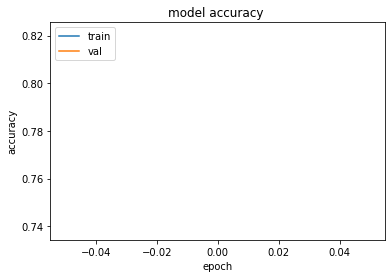

In [26]:
import matplotlib.pyplot as plt
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

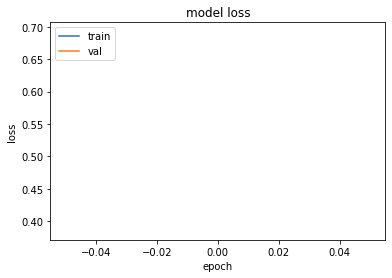

In [27]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
model.save("/content/drive/MyDrive/covid/densenet.h5")

In [29]:
model.evaluate(val_generator)

512/512 [==============================] - 607s 1s/step - loss: 0.6956 - accuracy: 0.7374


[0.6956140995025635, 0.7373601794242859]

In [30]:
pred=model.predict(val_generator)

In [34]:
pred=pred.round().astype(int)

In [39]:
val_generator.class_indices

{'covid': 0, 'non-covid': 1}

In [40]:
val_df.label=val_df.label.map(val_generator.class_indices)
print(classification_report(val_df.label,pred))

              precision    recall  f1-score   support

           0       0.78      0.65      0.71     32301
           1       0.71      0.82      0.76     33127

    accuracy                           0.74     65428
   macro avg       0.74      0.74      0.73     65428
weighted avg       0.74      0.74      0.74     65428



In [ ]:
pred=model.predict(test_generator)
pred=pred.round().astype(int)
test_df.label=test_df.label.map(test_generator.class_indices)
print(classification_report(test_df.label,pred))

# final evaluation on validation data

In [ ]:
#predictor=predictor.load('/content/drive/MyDrive/covid/predictor.ag')


In [ ]:
path,label=prepare('/content/val',split=False,flat=False)
len(path),len(label)

(374, 374)

In [ ]:
def evaluate(path,label):
  test_pred,test_true=[],[]
  for i, j in zip(path,label):
    test_df=pd.DataFrame(zip(i,j),columns=['image','label'])
    test_generator=data_gen.flow_from_dataframe(test_df,directory='',
                                                    target_size=(img_shape,img_shape),
                                                    x_col="image",
                                                    #y_col='label',
                                                    class_mode=None,
                                                    shuffle=False,
                                                    batch_size=batch_size)
    test_df.label=test_df.label.map(test_generator.class_indices)
    pred=model.predict(test_generator)
    pred=list(pred.round().astype(int))
    test_pred.append(max(pred,key=pred.count))
    test_true.append(test_df.label.mean())
  return test_pred,test_true

In [ ]:
%%capture
test_pred,test_true=evaluate(path,label)

In [ ]:
print(classification_report(test_true,test_pred,target_names=['non-covid','covid']))

              precision    recall  f1-score   support

   non-covid       0.79      0.99      0.88       209
       covid       0.98      0.67      0.79       165

    accuracy                           0.85       374
   macro avg       0.89      0.83      0.84       374
weighted avg       0.87      0.85      0.84       374

